In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import geohash
import re
import requests
import gensim.downloader as api
import gensim.parsing.preprocessing
stop = gensim.parsing.preprocessing.STOPWORDS

In [38]:
url = "https://dh-data-chef-hiring-test.s3.eu-central-1.amazonaws.com/products.gz"
df = pd.read_parquet(url, engine='pyarrow')

# Cleaning the Data (20 minutes)

## Cleaning the Data

First, I'll perform the "data cleanup: all non English and invalid items should be cleaned up".

In [39]:
print(df.shape)
df.head()

(300774, 6)


,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21zv3v,"Double Boiled Soup, Rice & 3 Dishes",Vegetarian,38
1,1,1,w21ztnr,Goreng Pisang,5 Pcs,26
2,2,2,w21ztje,Chicken Ham Sub,Lean and tender sliced chicken ham with your c...,31
3,3,3,w21zunx,Instant Noodles 快熟面,Per pc,88
4,4,4,w21zety,Mini Yolky Custard Pau,3 Pc,62


From panning through the data, a few notes:

* Remove all non-English words
* Some `product_name`s and `product_description`s contain numbers. Some of these numbers are valuable information (e.g. '5oz', or '3 pcs'), and some are just menu enumerations at the beginning of the string (e.g. '735. Mushroom Soup' or  'V3. Chicken Organ Set'). I think it could be important to leave that stuff in for now, just because I can imagine some of the input being something like "Chicken Sandwich. With fries", and so some scheme of eliminating text before a period would be bad. If/when I get to some text processing and clustering of vendors, I'll circle back.

I wonder if the geohashes are all legal...

In [40]:
geohashes_transformed = df['vendor_geohash'].apply(lambda x: geohash.decode(x))
geohashes_transformed.head()

0    (1.3726043701171875, 103.94920349121094)
1    (1.3533782958984375, 103.94096374511719)
2    (1.3492584228515625, 103.93547058105469)
3    (1.3986968994140625, 103.89701843261719)
4    (1.3506317138671875, 103.87367248535156)
Name: vendor_geohash, dtype: object

So the geohashes are all legal, without diving through it more to see if anything's been somehow messed up. I wonder if there are any NaNs anywhere?

In [41]:
df.isna().describe()

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
count,300774,300774,300774,300774,300774,300774
unique,1,1,1,1,2,1
top,False,False,False,False,True,False
freq,300774,300774,300774,300774,184250,300774


The only column with NaNs is `product_description`. That's pleasant; nothing needs to be done here besides replacing the NaNs with an empty string.

In [42]:
df['product_description'] = df['product_description'].fillna(' ')

There's nothing else to clean for now. It's just the non-English text that needs to be removed. I can do that with some regex.

In [43]:
def text_cleaner(text):
    if not text:
        return text
    return re.sub(r'([^\x00-\x7A])+',' ', text)
df['product_description'] = df['product_description'].str.replace(r'[^\x00-\x7f]',' ')#apply(lambda x: text_cleaner(x))
df['product_name'] = df['product_name'].str.replace(r'[^\x00-\x7f]',' ')#.apply(lambda x: text_cleaner(x))
df.head()

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21zv3v,"Double Boiled Soup, Rice & 3 Dishes",Vegetarian,38
1,1,1,w21ztnr,Goreng Pisang,5 Pcs,26
2,2,2,w21ztje,Chicken Ham Sub,Lean and tender sliced chicken ham with your c...,31
3,3,3,w21zunx,Instant Noodles,Per pc,88
4,4,4,w21zety,Mini Yolky Custard Pau,3 Pc,62


Nice. Moving on to data exploration.

# Exploring the Data (90 minutes)

## Preliminary Statistics

In [44]:
df.describe(include='all')

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
count,300774.00000,300774.000000,300774,300774,300774,300774.000000
unique,NaN,NaN,2068,104759,33636,NaN
top,NaN,NaN,w21zetv,Coke,,NaN
freq,NaN,NaN,2921,739,184252,NaN
mean,150386.50000,2890.920528,NaN,NaN,NaN,9.215780
std,86826.11927,2012.265241,NaN,NaN,NaN,23.479511
min,0.00000,0.000000,NaN,NaN,NaN,1.000000
25%,75193.25000,1167.000000,NaN,NaN,NaN,1.000000
50%,150386.50000,2590.000000,NaN,NaN,NaN,3.000000
75%,225579.75000,4358.000000,NaN,NaN,NaN,8.000000


In [45]:
df.nunique()

product_id             300774
vendor_id                8173
vendor_geohash           2068
product_name           104759
product_description     33636
order_count               470
dtype: int64

This is interesting:
* The number of unique order_counts is 470, with the max being 2017. That probably is some exponential like thing, especially looking at the `.describe()` call (focused in on in the cell just below).
* There are 300774 unique `product_id`s in the data, as many as there are data points (i.e. it's a key), but there are only 105780 unique `product_name`s... what's up with that?
* There are 8173 `vendor_id`s. That seems manageable.

In [46]:
df.order_count.describe()

count    300774.000000
mean          9.215780
std          23.479511
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        2017.000000
Name: order_count, dtype: float64

## Understanding Distributions over Different Columns

### CDF of `product_id`s by `order_count`s

It may not be extremely relevant, necessarily, but I just want to see the distribution over `order_count`s. I anticipate an exponential distribution of sorts (i.e. the majority of products have just one order, and the minority of products have a lot). I particularly want to show it because it's possibly multi-modal in some way, due to different types of products, i.e. appetizer vs main course vs dessert vs drink.

Text(0, 0.5, 'CDF of Orders')

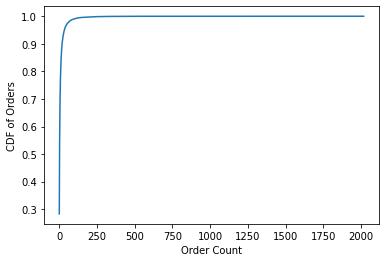

In [47]:
value_counts = Counter(df.order_count)
x, dist = zip(*[(i, value_counts[i]) for i in range(1, max(value_counts)+1)])
x = np.array(x)
dist = np.array(dist)
cdf = np.cumsum(dist)/len(df)
plt.plot(x, cdf)
plt.xlabel('Order Count')
plt.ylabel('CDF of Orders')

In [48]:
x[np.argmin(abs(cdf - .95))]

34

Wow, so 90% of the products have less than 34 orders over the whole 30 day period! Could a reasonable solution be to just look at the products in the top 5-10% and recommend them to everyone?

### CDF of vendors by total order_count by each vendor

Let's take a look at the distribution over number of total product sold by each vendor. This is useful to know because it'll color our product recommendation strategy a little bit, as total order volume is an important characteristic about a restaurant, and it'd be nice if the product recommendations can be targeted.

Text(0, 0.5, 'CDF of Vendors with that total order count')

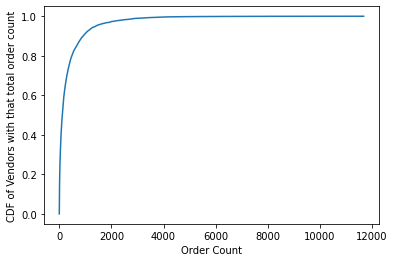

In [49]:
vendor_by_total_order_count = df[['vendor_id', 'order_count']].groupby('vendor_id').sum()
total_order_count_values = vendor_by_total_order_count['order_count'].value_counts().to_dict()
x, dist = [0]*(max(total_order_count_values)+1), [0]*(max(total_order_count_values)+1)
for i in range(1, max(total_order_count_values)+1):
    x[i] = i
    if i in total_order_count_values:
        dist[i] = total_order_count_values[i]
x = np.array(x)
dist = np.array(dist)
cdf = np.cumsum(dist)/sum(dist)
plt.plot(x, cdf)
plt.xlabel('Order Count')
plt.ylabel('CDF of Vendors with that total order count')

This looks pretty power-law-like again.

In [50]:
x[np.argmin(abs(cdf - .25))]

25

So, 25% of the vendors in the dataset had less than or equal to 25 orders in the past 30 days. That's not so bad, I think this will be alright to work with.

### CDF of vendors by total product_count by each vendor

This will likely look similar to the plot of "CDF of vendors by total order_count by each vendor".

Text(0, 0.5, 'CDF of Vendors with that Number of Products')

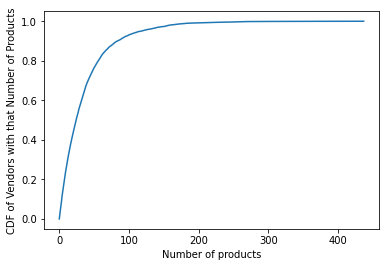

In [51]:
vendor_by_number_products = df[['vendor_id', 'product_id']].groupby('vendor_id').count()
number_product_values = vendor_by_number_products['product_id'].value_counts().to_dict()
x, dist = [0]*(max(number_product_values)+1), [0]*(max(number_product_values)+1)
for i in range(1, max(number_product_values)+1):
    x[i] = i
    if i in number_product_values:
        dist[i] = number_product_values[i]
x = np.array(x)
dist = np.array(dist)
cdf = np.cumsum(dist)/sum(dist)
plt.plot(x, cdf)
plt.xlabel('Number of products')
plt.ylabel('CDF of Vendors with that Number of Products')

It's not as quite as sharp as the vendor-by-total-order-count CDF, but still a power law of sorts

In [52]:
x[np.argmin(abs(cdf - .25))]

10

So, 25% of the vendors have less than or equal to 10 products only.

### Distribution over Geohashes

As we saw above in "Preliminary Statistics", there are 2068 unique geohashes. I wonder what the map of this looks like?

In [53]:
df['vendor_geohash'].value_counts().sort_values()

w21z7kz       1
w21z3w3       1
w21zt7t       1
w21z647       1
w21z7nr       1
           ... 
w23b4u5    2084
w23bh25    2234
w23b1tq    2281
w21z8dz    2302
w21zetv    2921
Name: vendor_geohash, Length: 2068, dtype: int64

Text(0, 0.5, 'number of vendors')

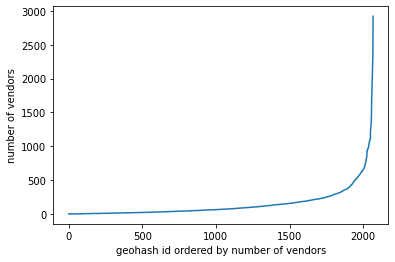

In [54]:
plt.plot(df['vendor_geohash'].value_counts().sort_values().values)
plt.xlabel('geohash id ordered by number of vendors')
plt.ylabel('number of vendors')

So it's interesting that this isn't more uniform. I'd expect, as with geohash, that the boxes are all of 'equal-data sizes'...perhaps not. I'd like to make a real geo-map of this, but I want to focus on using `product_name` and `product_description` features first. I'll circle back to this if there's time.

## Concluding Thoughts/Salient Observations
- There are 300774 unique `product_id`s in the data, as many as there are data points (i.e. it's a key), but there are only 105780 unique `product_name`s. A decision will have to be made about how to treat products.
- Unsurprisingly, all these CDFs I've plotted are power-law-like. The CDF of product_id order counts is particularly sharp.
- The CDF's don't have any multi-modal behavior that I was able to observe. I thought that there might be something interesting around identifying 'type' of product (e.g. appetizer, main dish, drink) by the order patterns (like drinks have more orders that main dishes), but nothing immediately jumps out. Though there still might be something hiding in the data. This would have been useful for making multiple recommendations to vendors, e.g. "this is the best main dish you should add; this is the best drink that you should add".

## My Standing Questions
- What is the meaning of the vendor geohash? How is it derived/what is the hashing function? It'd be useful to know in order to make targeted recommendations (e.g. if 'Double-Cheesburger' is the best selling product at barbecue places in the US, I'd like to suggest it to barbecue places in the US that aren't selling it, but I'm less likely to suggest it to barbecue places in Korea)
- "Design a solution that will help the vendors add new items to their menus"... does this mean "prototype a running system for doing this on a monthly basis", "explore different models/methods for recommending new products to vendors", or what?
- What's the objective function? How can I tell from this data that a vendor is successful? Ought I assume that, for the scope of this data, all products have the same revenue margin, and so the goal of each vendor is to sell as much product as possible?


# Making Recommendations  (110 minutes)

Mariia has answered my standing questions--thanks Mariia! So, it's time to move forward with making recommendations. But first, I need to make some assumptions so that this problem is sufficiently constrained:

## Assumptions
1. I assume that every product is unique. This is a reasonable assumption to make, because, even if two products have the same product name and product description, they could be completely different in real life. E.g. a 'hamburger' with the description 'no toppings' could be a completely different thing at two different vendors--one vendor could make their burgers on a cheap roll with a patty from a factory, and one could be made on a nice bun with home-made patties. Moreover, it's possible that one `vendor_a`'s 'burger' is more similar to `vendor_b`'s 'hamburger' than it is to `vendor_c`'s burger. Finally, for the envisioned use case of recommending products to vendors, I'd rather not inflect any of my bias onto saying what products are the same. I'd rather let vendors decide that for themselves.
2. I assume that all recommendations apply equally well to all vendors. This is obviously flawed, and it is this assumption that I will try to relax as I improve the recommendations.

With the assumptions explicitly set, the problem statement becomes: **"For each vendor, make a personalized recommendation of dishes that are likely to bring in more product orders"**. Model improvements will work towards the goal of improving the personalization of recommendations, which is tantamount to relaxing assumption (2).

## Approach 1: Top N products
Here, we simply report the 50 products that had the most orders in the past 30 days:

In [55]:
df.sort_values('order_count', ascending=False).head(50)

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
3447,3447,37,w23b4n3,Dry,,2017
12157,12157,638,w21zg1k,Dry,,1479
25972,25972,155,w21zs0h,2pc Chickenjoy with Regular Sides A La Carte,,1027
17979,17979,37,w23b4n3,Rice,,1018
22807,22807,2098,w21zv3v,Dry,,992
18988,18988,778,w21zu51,Spring Chicken Meal,Whole young and tender spring chicken served w...,969
10278,10278,37,w23b4n3,Instant Noodles,,963
1772,1772,476,w21zc5k,Ayam Penyet Town,Smashed fried chicken,939
18348,18348,280,w23b1tq,3pc Chicken Meal,"3 Pcs of chicken, 1 regular mashed potato, 1 h...",919
11444,11444,93,w21zujq,French Fries,Large,906


It is perhaps useful to note that 'Dry' is 3 out of the top 5 results. I imagine that this is not a particularly useful recommendation for a vendor, because, well, what does 'Dry' mean? That said, I also do not know what 'Laksa' means, nor 'Kampung Fried Rice'. I don't want to inflect my bias on the recommendations, so I leave the product 'Dry' in the dataset and recommendation list.

## Approach 2: Personalizing Recommendations by Understanding Vendor Menus
Chicken is mentioned in 23 of the top 50 products. So, what use does this list do for vegetarian restaurants?

To better personalize recommendations, it's useful to understand the vendors by virtue of the products that they offer--in other words, by their menu. I'll do this by getting a bag-of-words for each vendor and using pretrained word-embeddings to get a 'menu-embedding' for each vendor. Each vendor's bag of words will be the list of words found in all their products' names and descriptions. Some valuable data may be lost in the process, as it's possible that pretrained embeddings don't exist for certain common words. The menu-embedding of a vendor is the average of all of its words' embeddings. I'll remove stop-words as well.

One thing to be mindful of is that vendor_i's bag-of-words will likely have repeated words. There are 3 options for handling the averaging of the embeddings for those words:
1. Strip repeated words from the bag-of-words, such that the bag-of-words is now rather a 'set-of-words'
2. Leave repeated words as is.
3. Do some sort of log weighting scheme so that words that are repeated a lot of times for vendor don't drown out the other words, e.g. `word_embedding = log_10(9+(count(word))) * embedding(word)`

I'll start with method (2) because it's the easiest, and I can always circle back if I need to.

It's also important to note here that, as observed during 'Exploring the Data', a non-negligible amount of vendors have very few products. This will potentially cause issues that I'll have to be mindful of, and I may have to circle back to.

To be explicitly clear, the approach here is to **assign each vendor do a menu-cluster. For each menu-cluster, recommend to its constituent vendors the top products of that cluster**. A more robust strategy would be to do a nearest neighbors approach, rather, where we get the nearest neighbors to a vendor, and return the top products from those neighbors. However, I'm not yet very familiar with this dataset, and so having clusters is useful for introspecting the learned menus. 

In [56]:
# load the word vectors. I use glove vectors trained on twitter data because I think that it's more likely to contain 
# gloves for words like 'chickenjoy' than gloves trained on wikipedia data, for example.
word_vector_size = 50
word_vectors = api.load('glove-twitter-{wv}'.format(wv=word_vector_size)).wv

<ipython-input-56-126e47250830>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors = api.load('glove-twitter-{wv}'.format(wv=word_vector_size)).wv


In [57]:
df['word_bag'] = df.product_name.str.lower().str.replace('[^\w\s]',' ').str.split() + df.product_description.str.lower().str.replace('[^\w\s]',' ').str.split()
vendor_word_bags = df[['vendor_id','word_bag']].groupby('vendor_id').sum()
vendor_word_bags.head()

,word_bag
vendor_id,
0,"[double, boiled, soup, rice, 3, dishes, vegeta..."
1,"[goreng, pisang, 5, pcs, chocolate, cheese, ba..."
2,"[chicken, ham, sub, lean, and, tender, sliced,..."
3,"[instant, noodles, per, pc, fried, beancurd, 1..."
4,"[mini, yolky, custard, pau, 3, pc, shredded, k..."


In [58]:
def get_menu_embedding(word_bag):
    count = 0
    embedding = np.zeros((50,))
    for word in word_bag:
        if word in stop:
            continue
        try:
            embedding += word_vectors.word_vec(word)
            count += 1
        except KeyError:
            pass
    if count==0:
        print("I'm NaN: {wb}".format(wb=word_bag))
        return None
    return embedding/count
vendor_word_bags['menu_embedding'] = vendor_word_bags['word_bag'].apply(lambda x: get_menu_embedding(x))
vendor_word_bags.head()

I'm NaN: []
I'm NaN: ['heineiken']


,word_bag,menu_embedding
vendor_id,,
0,"[double, boiled, soup, rice, 3, dishes, vegeta...","[-0.13843838054192614, -0.2671570689892586, 0...."
1,"[goreng, pisang, 5, pcs, chocolate, cheese, ba...","[-0.3163336861568193, -0.2198996195414414, -0...."
2,"[chicken, ham, sub, lean, and, tender, sliced,...","[-0.11107837278900697, -0.24688132758541945, 0..."
3,"[instant, noodles, per, pc, fried, beancurd, 1...","[-0.1932869175884952, -0.28470280102919787, 0...."
4,"[mini, yolky, custard, pau, 3, pc, shredded, k...","[-0.21107159930604005, -0.19012794903726402, 0..."


Some of the vendors have nans, due to empty strings and a vendor who's only menu word was a mispelled beer brand.

In [59]:
vendor_word_bags = vendor_word_bags[vendor_word_bags['menu_embedding'].isna()==False]

Great. We have a menu embedding for each vendor and only tossed out two restaurants. Now, let's see if there any clusters. I'll do that first with a t-SNE.

In [60]:
menu_embedding_matrix = np.vstack(vendor_word_bags.menu_embedding.to_list())
menu_embedding_tsne = TSNE().fit_transform(menu_embedding_matrix)

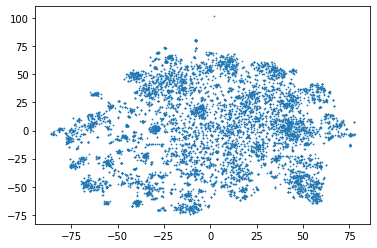

In [61]:
plt.scatter(menu_embedding_tsne[:,0],menu_embedding_tsne[:,1], s=.5)

There is certainly some separation in the data, so I'll go ahead with some clustering to find vendor clusters (I'm running out of time right now, as well).

DBSCAN is nice because I don't have to pre-specify the number of clusters that I'm expecting. Before using DBSCAN, however, I do need to do a little bit of figuring to see what a good choice for the epsilon hyperparameter would be.

To do this, I do a NearestNeighbors fit to find the distance to the minpts-1 nearest neighbors.

Text(0, 0.5, 'mean distance to nearest neighbors')

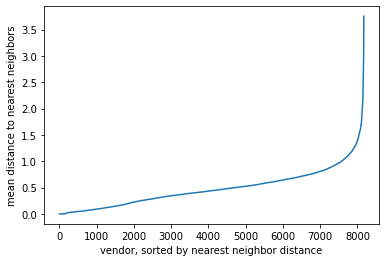

In [62]:
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(menu_embedding_matrix)
distances, indices = nbrs.kneighbors(menu_embedding_matrix)
distances = np.mean(distances[:, 1:], axis=1)
distances = np.sort(distances, axis=0)
plt.plot(distances)
plt.xlabel('vendor, sorted by nearest neighbor distance')
plt.ylabel('mean distance to nearest neighbors')

It looks like a good value for a DBSCAN of 5 minpts is ~1.3. I'll execute the DBSCAN and then plot the t-SNE again with some colors.

In [63]:
db = DBSCAN(eps=1.3, min_samples=5)
vendor_word_bags['cluster_id'] = db.fit_predict(menu_embedding_matrix)
vendor_word_bags.cluster_id.value_counts()

 0    7943
-1     218
 2       5
 1       5
Name: cluster_id, dtype: int64

Well... That DBSCAN didn't give us many clusters. Almost all the data is dominated by one cluster. Regardless of how correct this is, it doesn't seem particularly useful. I'll mess with the hyperparameters a little bit.

In [64]:
db = DBSCAN(eps=.8, min_samples=6)
vendor_word_bags['cluster_id'] = db.fit_predict(menu_embedding_matrix)
vendor_word_bags.cluster_id.value_counts().sort_values()

 10       5
 6        6
 8        6
 11       7
 7        8
 4        8
 1       10
 3       11
 2       12
 9       13
 5       16
-1     1241
 0     6828
Name: cluster_id, dtype: int64

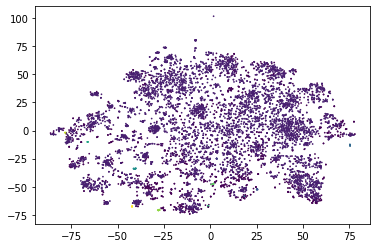

In [65]:
plt.scatter(menu_embedding_tsne[:,0],menu_embedding_tsne[:,1], s=.5, c=vendor_word_bags.cluster_id)

This t-SNE scatter plot is largely drowned out by the one big cluster, and a lot of the vendors are assigned the 'noise' label of -1. Alas. I must recall here that the many of the vendors hardly had any products on their menu, and thus didn't have a well learned menu-embedding to build these clusters from. Also, Mariia mentioned that the majority of Delivery Hero's market is in Asia, and I know nothing of the cuisine there. Perhaps this is what it is like, where the vast majority of the cuisine is dominated by one type of menu, and then there are a few small cuisines in addition.

For sake of completion, I'll generate a recommendation list for each cluster. **For vendors who are assigned a cluster of -1, this 'model' just recommends using the Approach 1 'menu-agnostic' recommendations**

In [66]:
vendor_word_bags_4_merge = vendor_word_bags.reset_index()
vendor_word_bags_4_merge.head()
df_w_cluster = df.merge(vendor_word_bags_4_merge[['vendor_id', 'cluster_id']], how='left', on='vendor_id')
df_w_cluster.head()

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,word_bag,cluster_id
0,0,0,w21zv3v,"Double Boiled Soup, Rice & 3 Dishes",Vegetarian,38,"[double, boiled, soup, rice, 3, dishes, vegeta...",0.0
1,1,1,w21ztnr,Goreng Pisang,5 Pcs,26,"[goreng, pisang, 5, pcs]",-1.0
2,2,2,w21ztje,Chicken Ham Sub,Lean and tender sliced chicken ham with your c...,31,"[chicken, ham, sub, lean, and, tender, sliced,...",0.0
3,3,3,w21zunx,Instant Noodles,Per pc,88,"[instant, noodles, per, pc]",0.0
4,4,4,w21zety,Mini Yolky Custard Pau,3 Pc,62,"[mini, yolky, custard, pau, 3, pc]",0.0


Now that we have cluster_id merged in with the product dataframe, all we have to do is groupby cluster_id and get the top products for each cluster.

In [67]:
df_for_rec = df_w_cluster[['product_id', 'vendor_id', 'vendor_geohash', 'product_name', 'product_description', 'cluster_id', 'order_count']]
for cluster_label in range(max(db.labels_)+1):
    print(cluster_label)
    display(df_for_rec[df_for_rec.cluster_id==cluster_label].sort_values('order_count', ascending=False).head(10))

0


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
3447,3447,37,w23b4n3,Dry,,0.0,2017
12157,12157,638,w21zg1k,Dry,,0.0,1479
17979,17979,37,w23b4n3,Rice,,0.0,1018
22807,22807,2098,w21zv3v,Dry,,0.0,992
18988,18988,778,w21zu51,Spring Chicken Meal,Whole young and tender spring chicken served w...,0.0,969
10278,10278,37,w23b4n3,Instant Noodles,,0.0,963
1772,1772,476,w21zc5k,Ayam Penyet Town,Smashed fried chicken,0.0,939
18348,18348,280,w23b1tq,3pc Chicken Meal,"3 Pcs of chicken, 1 regular mashed potato, 1 h...",0.0,919
11444,11444,93,w21zujq,French Fries,Large,0.0,906
12379,12379,796,w21zc5q,2. Koo Kee Special Noodle,,0.0,834


1


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
25921,25921,1381,w21zg17,White Rice,,1.0,148
1004,1004,746,w21ze4v,White Rice,,1.0,129
21518,21518,1381,w21zg17,Enoki Mushroom,100 gm,1.0,126
6971,6971,1381,w21zg17,Potato,200 gm,1.0,124
14778,14778,1381,w21zg17,Pork Belly,100 gm,1.0,118
11155,11155,746,w21ze4v,Enoki Mushroom,100 gm,1.0,101
16981,16981,1381,w21zg17,Luncheon Meat,100 gm,1.0,100
15895,15895,1381,w21zg17,Ee Mee E,1 Pc,1.0,100
18114,18114,1381,w21zg17,Spicy,,1.0,99
9256,9256,1381,w21zg17,Mild Spicy,,1.0,93


2


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
11472,11472,109,w21z3mt,Chao Yuan Sliced Abalone Minced Meat Noodles ...,,2.0,148
21235,21235,2036,w21z6fp,Chao Yuan Sliced Abalone Minced Meat Noodles ...,,2.0,113
4988,4988,350,w21zu5t,Chao Yuan Sliced Abalone Minced Meat Noodles ...,,2.0,99
19284,19284,109,w21z3mt,Chao Yuan Fishball Noodles,,2.0,76
13033,13033,482,w21zt26,Chao Yuan Sliced Abalone Minced Meat Noodles ...,,2.0,75
142,142,109,w21z3mt,Chao Yuan Laksa,,2.0,73
1009,1009,749,w21zeff,Chao Yuan Sliced Abalone Minced Meat Noodles ...,,2.0,72
11154,11154,749,w21zeff,Chao Yuan Sliced Abalone Minced Meat Noodles ...,,2.0,69
25113,25113,350,w21zu5t,Chao Yuan Sliced Abalone Minced Meat Noodles ...,,2.0,69
22359,22359,2036,w21z6fp,Chao Yuan Sliced Abalone Minced Meat Noodles ...,,2.0,64


3


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
26739,26739,1602,w21zkjy,Wantan Mee,,3.0,342
5538,5538,1602,w21zkjy,Wantan Mee,,3.0,337
18506,18506,1077,w21zu1v,Wantan Mee,,3.0,249
12992,12992,1766,w21zc5n,Wantan Mee,,3.0,245
14057,14057,1077,w21zu1v,Wantan Mee,,3.0,217
17402,17402,1766,w21zc5n,Wantan Mee,,3.0,205
6048,6048,2113,w21z6dh,Wantan Mee,,3.0,150
4997,4997,365,w23b4u5,Wantan Mee,,3.0,146
2469,2469,1392,w21zts2,Wantan Noodle,,3.0,146
4408,4408,1602,w21zkjy,Fried Wantan,,3.0,141


4


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
24724,24724,1347,w21z6cb,3. Shui Kueh (5 Pcs),,4.0,134
5714,5714,1347,w21z6cb,3. Shui Kueh (10 Pcs),All sauces comes separately packed,4.0,116
1913,1913,564,w21zujq,3. Shui Kueh (5 Pcs),,4.0,113
8688,8688,564,w21zujq,3. Shui Kueh (10 Pcs),All sauces comes separately packed,4.0,111
2326,2326,1347,w21z6cb,7. Chee Chong Fun (2 pcs),,4.0,110
11623,11623,992,w21zkmn,3. Shui Kueh (5 Pcs),,4.0,110
9850,9850,564,w21zujq,7. Chee Chong Fun (2 pcs),,4.0,92
6281,6281,1133,w21zc6t,3. Shui Kueh (5 Pcs),,4.0,86
19726,19726,1133,w21zc6t,3. Shui Kueh (10 Pcs),All sauces comes separately packed,4.0,85
19836,19836,1177,w21zetv,3. Shui Kueh (5 Pcs),,4.0,82


5


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
24486,24486,3263,w23bh25,Medium Yole Box,500ml | Comes with 3 complimentary toppings,5.0,115
27187,27187,2989,w21zc4y,Medium Yole Box - Signature Frozen,500ml | Comes with 3 complimentary toppings,5.0,79
25540,25540,3263,w23bh25,Large Yole Box,1000ml | Comes with 5 complimentary toppings,5.0,69
13398,13398,2721,w21xxgu,Medium Yole Box,500ml | Comes with 3 complimentary toppings,5.0,64
15520,15520,2926,w21zscn,Medium Yole Box - Signature Frozen,500ml | Comes with 3 complimentary toppings,5.0,53
9614,9614,2286,w23b1tq,Medium Yole Box,500ml | Comes with 3 complimentary toppings,5.0,51
7360,7360,2286,w23b1tq,Large Yole Box,1000ml | Comes with 5 complimentary toppings,5.0,49
19303,19303,931,w21z8vg,Medium Yole Box,500ml | Comes with 3 complimentary toppings,5.0,49
1318,1318,931,w21z8vg,Large Yole Box,1000ml | Comes with 5 complimentary toppings,5.0,36
17183,17183,2989,w21zc4y,Large Yole Box - Signature Frozen,1000ml | Comes with 5 complimentary toppings,5.0,34


6


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
17714,17714,1244,w21zujm,Custard Pie Puff,,6.0,95
24462,24462,1244,w21zujm,Premium D24 Durian Pie Puff,,6.0,67
25700,25700,3299,w21zs0j,Custard Pie Puff,,6.0,50
17710,17710,1244,w21zujm,Classic Favourites Assorted Box,"Box of 6 Assorted Custard pies: 2xCustard Pie,...",6.0,49
8838,8838,1244,w21zujm,Custard Eclair Puff,,6.0,43
21134,21134,1244,w21zujm,Chocolate Pie Puff,,6.0,41
18083,18083,2589,w21ztq1,Custard Pie Puff,,6.0,39
10358,10358,2589,w21ztq1,Classic Favourites Assorted Box,"Box of 6 Assorted Custard pies: 2xCustard Pie,...",6.0,34
11069,11069,1244,w21zujm,Chocolate Fondant,Chocolate cake filled with molten chocolate,6.0,27
2065,2065,1244,w21zujm,Chocolate Eclair Puff,,6.0,24


7


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
247132,247132,5301,w23b4u7,Udhayam Ponni Rice | 5 kg,,7.0,7
241811,241811,4900,w21zuqu,Udhayam Ponni Rice | 5 kg,,7.0,7
214362,214362,4900,w21zuqu,SM Idly Rice | 5 kg,,7.0,5
211133,211133,4900,w21zuqu,SM Pattai (Cinnamon Stick) | 80 g,,7.0,5
211126,211126,4900,w21zuqu,SM Cumin (Jeeragam) | 100 g,,7.0,5
199667,199667,4900,w21zuqu,SM Dry Red Chilli Long | 100 g,,7.0,4
194600,194600,4900,w21zuqu,SM Green Moong Split | 500 g,,7.0,4
204366,204366,5301,w23b4u7,SM Appalam | 120 g,,7.0,4
174384,174384,4900,w21zuqu,SM Mustard Mix | 100 g,,7.0,3
159082,159082,4900,w21zuqu,SM Classic Basmati Rice | 1 kg,,7.0,3


8


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
23803,23803,2748,w21ztmk,Mee Rebus Set A,,8.0,51
12655,12655,2748,w21ztmk,Mee Siam Set A,,8.0,46
20415,20415,2748,w21ztmk,Big Siew Mai,,8.0,29
20426,20426,2748,w21ztmk,Prawn Dumplings,,8.0,27
27065,27065,2748,w21ztmk,Mee Siam Set B,,8.0,25
300235,300235,2748,w21ztmk,Mee Rebus Set B,,8.0,21
297896,297896,2748,w21ztmk,Chwee Kuay,,8.0,20
297395,297395,2748,w21ztmk,Fan Choi,,8.0,19
296134,296134,2748,w21ztmk,Lontong Set B,,8.0,19
295755,295755,2748,w21ztmk,Lontong Set A,,8.0,19


9


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
233505,233505,5835,w21xxgu,GNC Optimum Nutrition Gold Standard 100% Whey ...,2.07Lbs,9.0,6
182890,182890,7632,w21zscn,GNC Optimum Nutrition Gold Standard 100% Whey ...,2.07Lbs,9.0,3
157748,157748,8101,w21zujm,GNC Optimum Nutrition Gold Standard 100% Whey ...,2.07Lbs,9.0,2
134551,134551,7028,w23b4rx,GNC Optimum Nutrition Gold Standard 100% Whey ...,2.07Lbs,9.0,2
123805,123805,6650,w21z7q9,GNC Optimum Nutrition Gold Standard 100% Whey ...,2.07Lbs,9.0,2
72816,72816,6936,w21z3m2,GNC Optimum Nutrition Gold Standard 100% Whey ...,2.07Lbs,9.0,1
100231,100231,7632,w21zscn,LAC Taut Collagen Mask | 5 pieces,,9.0,1
94997,94997,7028,w23b4rx,GNC Total Lean Advanced Premium CLA 3-6-9 | 12...,,9.0,1
83307,83307,7761,w21zv3v,GNC Optimum Nutrition Gold Standard 100% Whey ...,2.07Lbs,9.0,1
80887,80887,5835,w21xxgu,GNC Optimum Nutrition Gold Standard 100% Whey ...,2Lbs,9.0,1


10


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
200340,200340,7542,w21zu1q,Brownies with Chocolate Chips,,10.0,4
151319,151319,7542,w21zu1q,Lemon Butter Cake,,10.0,2
151325,151325,7542,w21zu1q,Marble Cake,,10.0,2
49308,49308,6967,w21zkyv,Chocolate Chip Cookie Dough PINT,"458ml, vanilla ice cream with gobs of chocolat...",10.0,1
56176,56176,6967,w21zkyv,Strawberry Cheesecake PINT,"458ml, strawberries and a thick graham cracker...",10.0,1
68351,68351,7542,w21zu1q,Iced Chocolate,,10.0,1
76776,76776,6967,w21zkyv,Chocolate Fudge Brownie PINT,"458ml, chocolate ice cream with fudge brownies",10.0,1
78786,78786,7542,w21zu1q,Blueberry Cheesecake & Coffee,,10.0,1
79156,79156,7698,w21zs85,Chocolate Fudge Brownie PINT,"458ml, chocolate ice cream with fudge brownies",10.0,1
81705,81705,7736,w21zdvk,Chocolate Chip Cookie Dough PINT,"458ml, vanilla ice cream with gobs of chocolat...",10.0,1


11


,product_id,vendor_id,vendor_geohash,product_name,product_description,cluster_id,order_count
259550,259550,8165,w23b1my,Tiger Chilled Beer | 6x320 ml,"Delivered ice cold to your doorstep, brewed fr...",11.0,9
114935,114935,7987,w21zd2v,Tiger Chilled Beer | 6x320 ml,"Delivered ice cold to your doorstep, brewed fr...",11.0,2
137862,137862,8067,w21zdcp,Tiger Chilled Beer | 6x320 ml,"Delivered ice cold to your doorstep, brewed fr...",11.0,2
64774,64774,7469,w21zdvf,Tiger Chilled Beer | 6x320 ml,"Delivered ice cold to your doorstep, brewed fr...",11.0,1
91757,91757,7834,w21zexw,Tiger Chilled Beer | 6x320 ml,"Delivered ice cold to your doorstep, brewed fr...",11.0,1
95536,95536,7864,w21zkyv,Tiger Chilled Beer | 6x320 ml,"Delivered ice cold to your doorstep, brewed fr...",11.0,1
98880,98880,7891,w21zekx,Tiger Chilled Beer | 6x320 ml,"Delivered ice cold to your doorstep, brewed fr...",11.0,1


Some observations from this:
- The recommendations of Cluster 0 looks to be very similar to those of Approach 1, which makes sense since it contains the majority of the vendors
- Cluster 1 seems reasonable
- Cluster 2 contains a bunch of the same `product_name` from different `vendor_ids`. Perhaps my assumption 1 was not a good one to make. Or, maybe this cluster just discoverd some vendors that are part of the same franchise.
- Cluster 3 has a similar behavior to Cluster 2
- Cluster 4 has a similar behavior to Clusters 2 and 3
- There is some genuine vendor separation in the data. Cluster 6 recommends a lot of 'puff' and 'custard' desserts Cluster 9 recommends a lot of desserts, and they're notably different from those in Cluster 6 (though the order counts are very low); Cluster 8 deals exclusively with nutritional/fitness supplements.
- Cluster 10 indicates to me that I should go back and do the log-weighting scheme when building the menu embedding. Or, maybe what's going on is that when these vendors decide to sell 'Tiger Chilled Beer', there's an automated message that they can put on their menu

## Conclusions, Next Steps
Well, this analysis leaves me with more questions than I started with. Next steps that I would take are:
1. Improve the preprocessing:
    - Some log-weighting scheme during learning of menu embeddings would likely be helpful, as seen by the repeated recommendations
    - Do some more rigorous analysis to figure out the best corpus to use for glove vectors.
    - I did a bunch of data exploration at the beginning to see which vendors had a very small total `order_count` or total number of `product_id`s. It could be useful to threshold some of them out, and only make targeted recommendations for vendors for which it is possible to reasonably assess their type.
2. It'd be nice to, instead of finding clusters for each vendor, do some sort of 'fuzzy recommendation'. To do this, I could do a nearest neighbors approach (as mentioned above) where I find the N closest vendors to `vendor_i`, and then recommend the top 50 products from those N neighbors to `vendor_i`. Product reThat'd be far more robust than what I've done (i.e. I tinkered with the DBSCAN hyperparameters quite a bit). It's also likely more directly useful. Though, making and having the clusters on-hand was certainly a useful first approach for introspecting on the model and the menu-embeddings.
3. I didn't really get the chance to dive into the `vendor_geohash` attribute much. I prioritized the `product_name` and `product_description` features because I intuitively thought it'd be more useful for clustering vendors. I think that `vendor_geohash` would be useful, and it'd fit in very nicely with the 'N nearest vendors' approach proposed in (2).
4. It'd be nice to categorize products as 'drink', 'appetizer', 'meal', etc. Or have any sort of labelling, and use that to provide categorized recommendation lists to each vendor.
5. The approach taken throughout this analysis has been to recommend the top N products to `vendor_i`. But, what if `vendor_i` already is the top seller of evreybody else? What should I recommend to `vendor_i`? In that case, it'd be neat to offer a sort of 'exploit' vs 'explore' option for a vendor, where, if the vendor is already highly performant, then you suggest diverse options that are somehow outliers or are 'rising products'. This problem, too, would certainly helped by the 'N nearest vendors' approach suggested in (2).

Thanks for your time in reading this!